In [ ]:
########################## Kidney disease prediction ########################################

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\sugan\Downloads\MLprj2\kidney_disease.csv")
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [204]:
df.replace('?', np.nan, inplace=True)

In [208]:
print(df['classification'].value_counts())
print(df['classification'].value_counts(normalize=True)) 

classification
ckd       250
notckd    150
Name: count, dtype: int64
classification
ckd       0.625
notckd    0.375
Name: proportion, dtype: float64


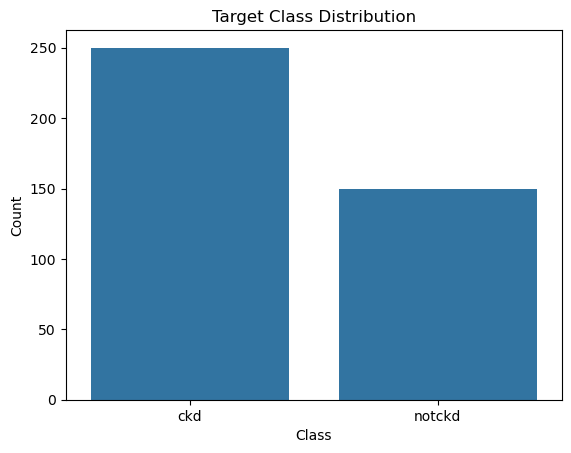

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='classification')
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [210]:
X = df.drop(['classification'], axis=1, errors='ignore')
y = df["classification"]

In [211]:
print(df['classification'].unique())

['ckd' 'notckd']


In [212]:
# Map target labels explicitly
target_map = {'ckd': 1, 'notckd': 0}
y = df['classification'].map(target_map)

In [213]:
if y.isnull().any():
    print("Found unexpected labels in target after mapping:")
    print(df.loc[y.isnull(), 'classification'].unique())

In [214]:
kidney_features=X.columns.tolist()   
import pickle

with open('kidney_features.pkl', 'wb') as f:
    pickle.dump(kidney_features, f)

In [215]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns.tolist()


In [ ]:
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
for col in numerical_cols:
   df[col] = df[col].fillna(df[col].mean())

In [216]:
print('Categorical columns:', categorical_cols)
print('Numerical columns:', numerical_cols)

Categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
Numerical columns: ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']


In [217]:
print(df.isnull().sum())

id                  0
age                 0
bp                  0
sg                  0
al                  0
su                  0
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                 0
bu                  0
sc                  0
sod                 0
pot                 0
hemo                0
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [218]:
# Fill missing values in numerical columns with mean
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        mean_value = X[col].mean()
        X[col].fillna(mean_value, inplace=True)

In [220]:
# Fill missing values in categorical columns with mode
for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        mode_value = X[col].mode()[0]
        X[col] = X[col].fillna(mode_value)

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [226]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(X_train[categorical_cols])
# Transform categorical columns in train and test
X_train[categorical_cols] = enc.transform(X_train[categorical_cols])
X_test[categorical_cols] = enc.transform(X_test[categorical_cols])

In [227]:
from sklearn.impute import SimpleImputer
# Impute missing values in numerical columns if needed (example: median imputation)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols)
imputer = SimpleImputer(strategy='median')
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

In [228]:
import pickle

with open('ordinal_encoder.pkl', 'wb') as f:
    pickle.dump(enc, f)

In [229]:
# Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) 


In [230]:
import pickle   

with open('kidneyscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [231]:
# Handle imbalance with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [232]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
lok_reg = LogisticRegression(
    C=0.001,          
    max_iter=1000,
    class_weight="balanced"
)
lok_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000)

In [233]:
import pickle

with open('lok_reg.pkl', 'wb') as f:
    pickle.dump(lok_reg, f)

In [234]:
# Evaluate
train_acc = lok_reg.score(X_train_resampled, y_train_resampled)
test_acc = lok_reg.score(X_test, y_test)

In [235]:
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.9225
Test Accuracy: 0.8875


In [236]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, lok_reg.predict(X_test)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, lok_reg.predict(X_test)))





Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.92      0.90      0.91        50

    accuracy                           0.89        80
   macro avg       0.88      0.88      0.88        80
weighted avg       0.89      0.89      0.89        80


Confusion Matrix:
[[26  4]
 [ 5 45]]
